In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


EMA12 and EMA26 Crossover with exit at EMA7

<ipython-input-5-0998a4ddbfea>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][data['EMA12'] < data['EMA26']] = 1
<ipython-input-5-0998a4ddbfea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ExitSignal'][data['close'] > data['EMA7']] = -1


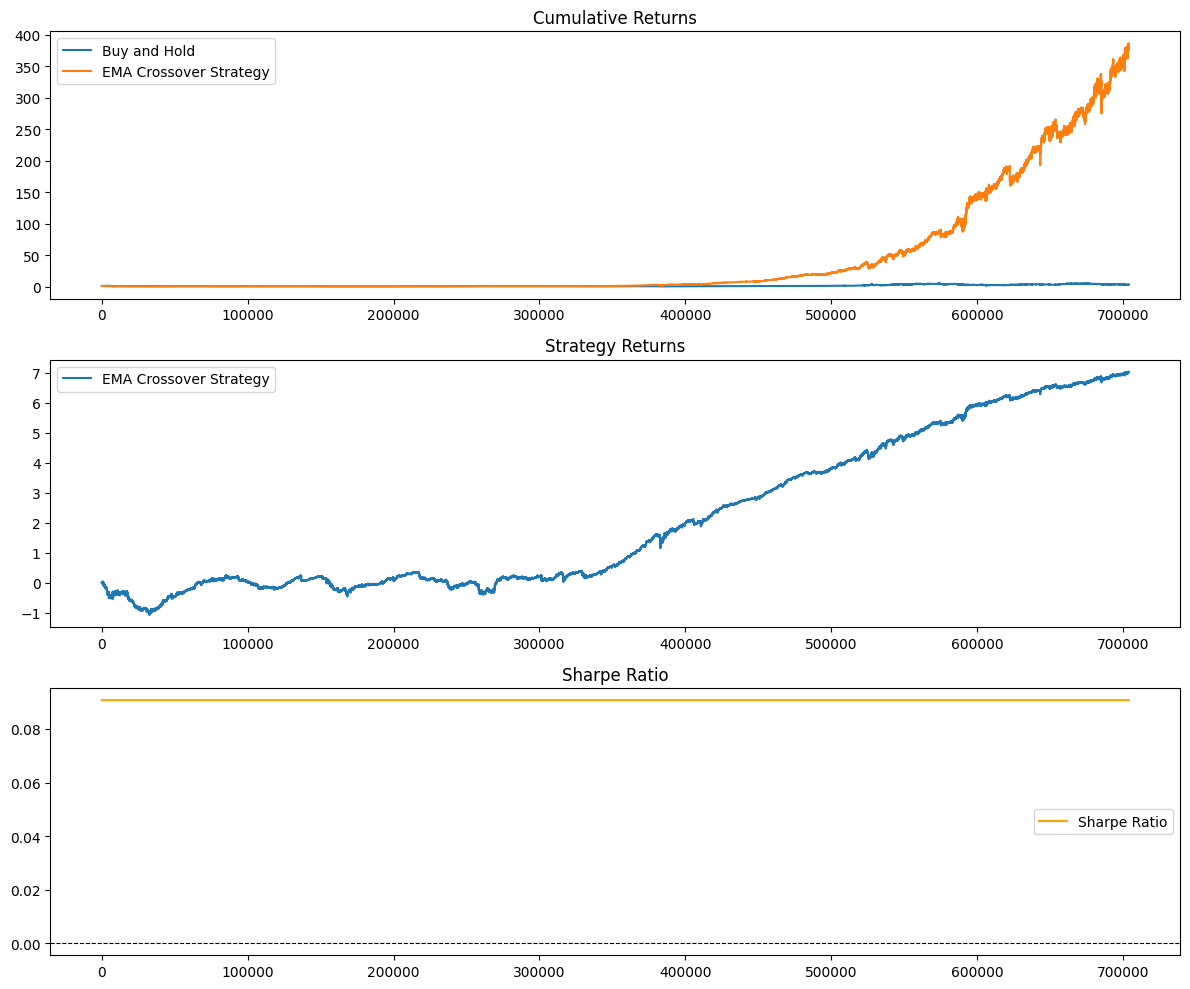

Sharpe Ratio: 0.0908


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

#symbol = "BTC-USD"
# Specify the intraday start and end times
#intraday_start = datetime(2023, 11, 3, 0, 0, 0)  # Example: 9:00 AM
#intraday_end = datetime(2023, 11, 9, 0, 0, 0)    # Example: 4:00 PM

# Download intraday data
#data = yf.download(symbol, start=intraday_start, end=intraday_end, interval="5m")

data = pd.read_csv('/content/drive/MyDrive/btcusdt_3m.csv')
#print(data)
data['EMA12'] = data['close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['close'].ewm(span=26, adjust=False).mean()
data['EMA7'] = data['close'].ewm(span=7, adjust=False).mean()

data['Signal'] = 0
#data['Signal'][data['EMA12'] > data['EMA26']] = -1
data['Signal'][data['EMA12'] < data['EMA26']] = 1

# Exit at EMA7
data['ExitSignal'] = 0
data['ExitSignal'][data['close'] > data['EMA7']] = -1
#data['ExitSignal'][data['close'] < data['EMA7']] = 1
data['FinalSignal'] = data['Signal'] + data['ExitSignal']

data['Position'] = data['FinalSignal'].shift(1)  # Enter/exit the position on the next day
data['Position'].fillna(0, inplace=True)  # Fill NaN with 0 for the first day
data['DailyReturns'] = data['close'].pct_change()
data['StrategyReturns'] = data['Position'] * data['DailyReturns']
data['CumulativeReturns'] = (1 + data['DailyReturns']).cumprod()
data['CumulativeStrategyReturns'] = (1 + data['StrategyReturns']).cumprod()

average_strategy_return = data['StrategyReturns'].mean()
std_dev_strategy_return = data['StrategyReturns'].std()
sharpe_ratio = np.sqrt(252)*average_strategy_return / std_dev_strategy_return

plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.plot(data['CumulativeReturns'], label='Buy and Hold')
plt.plot(data['CumulativeStrategyReturns'], label='EMA Crossover Strategy')
plt.legend()
plt.title('Cumulative Returns')

plt.subplot(3, 1, 2)
plt.plot(data['StrategyReturns'].cumsum(), label='EMA Crossover Strategy')
plt.legend()
plt.title('Strategy Returns')

plt.subplot(3, 1, 3)
sharpe_ratio_series = pd.Series(index=data.index, data=sharpe_ratio)
plt.plot(sharpe_ratio_series, label='Sharpe Ratio', color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.title('Sharpe Ratio')
plt.tight_layout()
plt.show()

print(f'Sharpe Ratio: {sharpe_ratio:.4f}')


In [ ]:
def atr(DF,n):
    df=DF.copy()
    df['High-Low']=abs(df['high']-df['low'])
    df['High-PreviousClose']=abs(df['high']-df['close'].shift(1))
    df['Low-PreviousClose']=abs(df['low']-df["close"].shift(1))
    df['TrueRange']=df[['High-Low','High-PreviousClose','Low-PreviousClose']].max(axis=1,skipna=False)
    df['ATR']=df['TrueRange'].ewm(com=n,min_periods=n).mean()
    return df['ATR']
n=10
data['ATR']=atr(data,n)

def supertrend(DF,n,m):
    df = DF.copy()
    df['ATR'] = atr(df,n)
    df["BASIC_UPPERBAND"]=((df['high']+df['low'])/2) + m*df['ATR']
    df["BASIC_LOWERBAND"]=((df['high']+df['low'])/2) - m*df['ATR']
    df["FINAL_UPPERBAND"]=df["BASIC_UPPERBAND"]
    df["FINAL_LOWERBAND"]=df["BASIC_LOWERBAND"]
    ind = df.index
    for i in range(n,len(df)):
        if df['close'][i-1]<=df['FINAL_UPPERBAND'][i-1]:
            df.loc[ind[i],'FINAL_UPPERBAND']=min(df['BASIC_UPPERBAND'][i],df['FINAL_UPPERBAND'][i-1])
        else:
            df.loc[ind[i],'FINAL_UPPERBAND']=df['BASIC_UPPERBAND'][i]
    for i in range(n,len(df)):
        if df['close'][i-1]>=df['FINAL_LOWERBAND'][i-1]:
            df.loc[ind[i],'FINAL_LOWERBAND']=max(df['BASIC_LOWERBAND'][i],df['FINAL_LOWERBAND'][i-1])
        else:
            df.loc[ind[i],'FINAL_LOWERBAND']=df['BASIC_LOWERBAND'][i]
    df['Strend']=np.nan
    for test in range(n,len(df)):
        if df['close'][test-1]<=df['FINAL_UPPERBAND'][test-1] and df['Close'][test]>df['FINAL_UPPERBAND'][test]:
            df.loc[ind[test],'Strend']=df['FINAL_LOWERBAND'][test]
            break
        if df['close'][test-1]>=df['FINAL_LOWERBAND'][test-1] and df['Close'][test]<df['FINAL_LOWERBAND'][test]:
            df.loc[ind[test],'Strend']=df['FINAL_UPPERBAND'][test]
            break
    for i in range(test+1,len(df)):
        if df['Strend'][i-1]==df['FINAL_UPPERBAND'][i-1] and df['Close'][i]<=df['FINAL_UPPERBAND'][i]:
            df.loc[ind[i],'Strend']=df['FINAL_UPPERBAND'][i]
        elif  df['Strend'][i-1]==df['FINAL_UPPERBAND'][i-1] and df['Close'][i]>=df['FINAL_UPPERBAND'][i]:
            df.loc[ind[i],'Strend']=df['FINAL_LOWERBAND'][i]
        elif df['Strend'][i-1]==df['FINAL_LOWERBAND'][i-1] and df['Close'][i]>=df['FINAL_LOWERBAND'][i]:
            df.loc[ind[i],'Strend']=df['FINAL_LOWERBAND'][i]
        elif df['Strend'][i-1]==df['FINAL_LOWERBAND'][i-1] and df['Close'][i]<=df['FINAL_LOWERBAND'][i]:
            df.loc[ind[i],'Strend']=df['FINAL_UPPERBAND'][i]
    return df['Strend']

n=10
m=3
data['supertrend']=supertrend(data,n,m)

KeyboardInterrupt: ignored

Breakout Strategy

[*********************100%%**********************]  1 of 1 completed


<ipython-input-7-a785507486af>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['LongSignal'][data['Close'] > (1 + breakout_threshold) * data['PreviousClose']] = 1


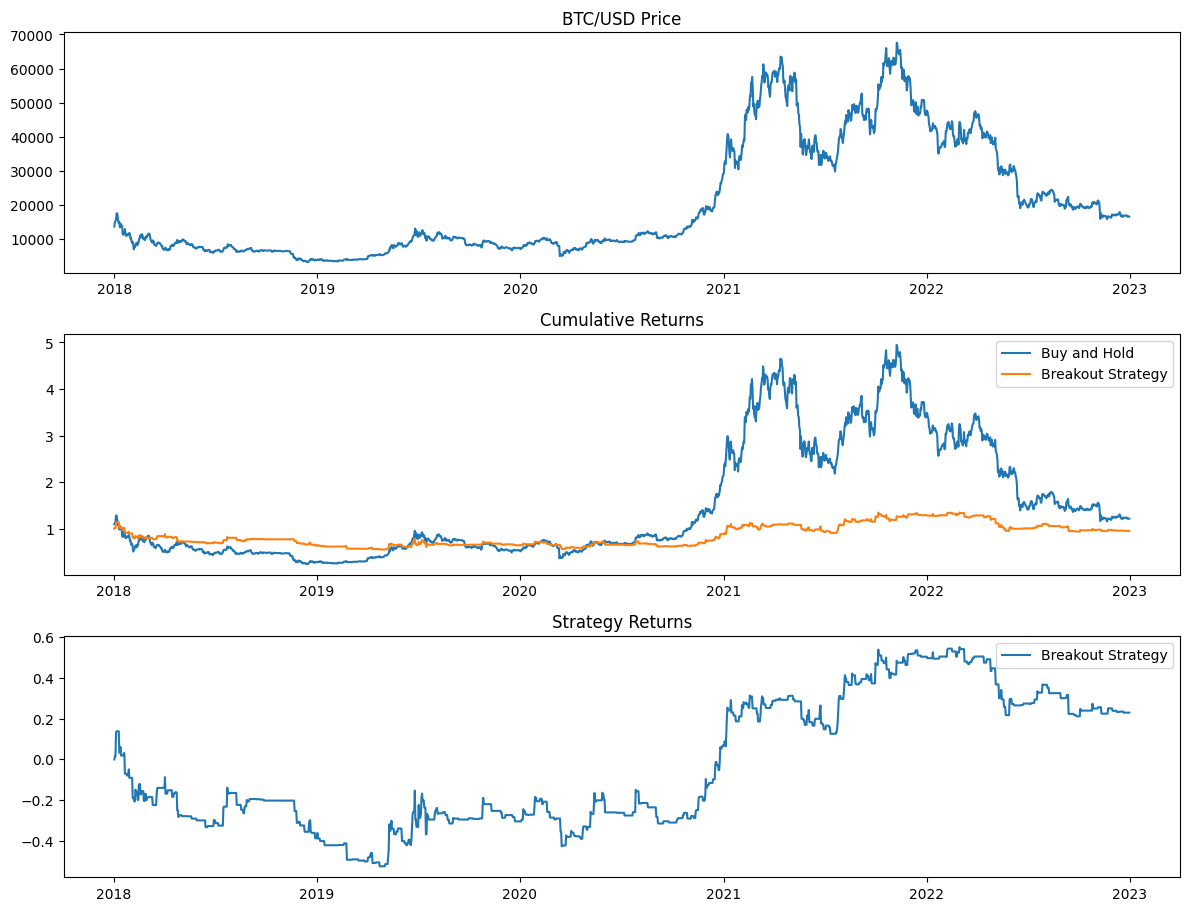

Sharpe Ratio: 0.1140


In [7]:
import yfinance as yf
symbol = "BTC-USD"
start_date = "2018-01-01"
end_date = "2023-01-01"
data = yf.download(symbol, start=start_date, end=end_date)

breakout_threshold = 0.02  # 2% breakout threshold
data['PreviousClose'] = data['Close'].shift(1)
data['LongSignal'] = 0
data['LongSignal'][data['Close'] > (1 + breakout_threshold) * data['PreviousClose']] = 1

data['Position'] = data['LongSignal'].shift(1)  # Enter the position on the next day
data['Position'].fillna(0, inplace=True)  # Fill NaN with 0 for the first day
data['DailyReturns'] = data['Close'].pct_change()
data['StrategyReturns'] = data['Position'] * data['DailyReturns']
data['CumulativeReturns'] = (1 + data['DailyReturns']).cumprod()
data['CumulativeStrategyReturns'] = (1 + data['StrategyReturns']).cumprod()

average_strategy_return = data['StrategyReturns'].mean()
std_dev_strategy_return = data['StrategyReturns'].std()
sharpe_ratio = np.sqrt(252)*average_strategy_return / std_dev_strategy_return

plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 1)
plt.plot(data['Close'], label='BTC/USD')
plt.title('BTC/USD Price')

plt.subplot(4, 1, 2)
plt.plot(data['CumulativeReturns'], label='Buy and Hold')
plt.plot(data['CumulativeStrategyReturns'], label='Breakout Strategy')
plt.legend()
plt.title('Cumulative Returns')

plt.subplot(4, 1, 3)
plt.plot(data['StrategyReturns'].cumsum(), label='Breakout Strategy')
plt.legend()
plt.title('Strategy Returns')


plt.tight_layout()
plt.show()

print(f'Sharpe Ratio: {sharpe_ratio:.4f}')


Optimised a little for sharpe, still a lot of improvement to be done.

[*********************100%%**********************]  1 of 1 completed


<ipython-input-8-3b2b06bcbfdc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['LongSignal'][data['Close'] > (1 + breakout_threshold * data['Volatility']) * data['PreviousClose']] = 1


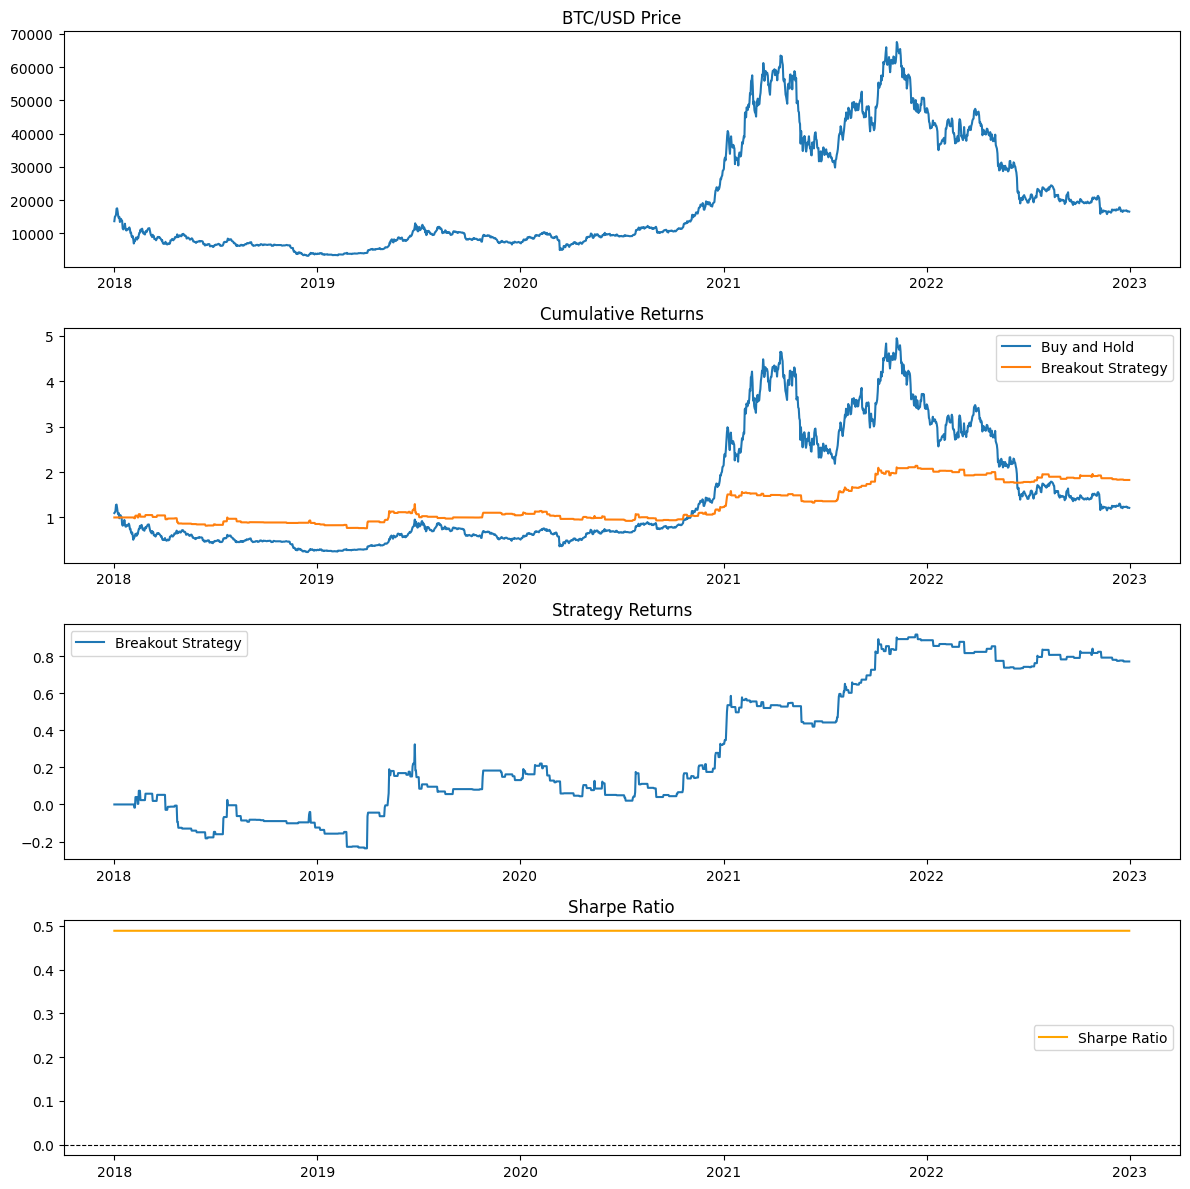

Sharpe Ratio: 0.4887


In [8]:
symbol = "BTC-USD"
start_date = "2018-01-01"
end_date = "2023-01-01"
data = yf.download(symbol, start=start_date, end=end_date)

# Calculate volatility (standard deviation of daily returns)
data['Volatility'] = data['Close'].pct_change().rolling(window=20).std()

# Use a volatility-based breakout threshold
breakout_threshold = 1  # Adjust as needed based on your analysis
data['PreviousClose'] = data['Close'].shift(1)
data['LongSignal'] = 0
data['LongSignal'][data['Close'] > (1 + breakout_threshold * data['Volatility']) * data['PreviousClose']] = 1
data['Position'] = data['LongSignal'].shift(1)  # Enter the position on the next day
data['Position'].fillna(0, inplace=True)  # Fill NaN with 0 for the first day

data['DailyReturns'] = data['Close'].pct_change()
data['StrategyReturns'] = data['Position'] * data['DailyReturns']
data['CumulativeReturns'] = (1 + data['DailyReturns']).cumprod()
data['CumulativeStrategyReturns'] = (1 + data['StrategyReturns']).cumprod()

average_strategy_return = data['StrategyReturns'].mean()
std_dev_strategy_return = data['StrategyReturns'].std()
sharpe_ratio = np.sqrt(252)*average_strategy_return / std_dev_strategy_return

plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 1)
plt.plot(data['Close'], label='BTC/USD')
plt.title('BTC/USD Price')

plt.subplot(4, 1, 2)
plt.plot(data['CumulativeReturns'], label='Buy and Hold')
plt.plot(data['CumulativeStrategyReturns'], label='Breakout Strategy')
plt.legend()
plt.title('Cumulative Returns')

plt.subplot(4, 1, 3)
plt.plot(data['StrategyReturns'].cumsum(), label='Breakout Strategy')
plt.legend()
plt.title('Strategy Returns')

plt.subplot(4, 1, 4)
sharpe_ratio_series = pd.Series(index=data.index, data=sharpe_ratio)
plt.plot(sharpe_ratio_series, label='Sharpe Ratio', color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.title('Sharpe Ratio')
plt.tight_layout()
plt.show()
print(f'Sharpe Ratio: {sharpe_ratio:.4f}')


Candle pairs startegy for 1 complete day

[*********************100%%**********************]  1 of 1 completed


<ipython-input-9-97318687e253>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CandleColor'][data['Close'] > data['Open']] = 'Green'
<ipython-input-9-97318687e253>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CandleColor'][data['Close'] < data['Open']] = 'Red'
<ipython-input-9-97318687e253>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'][i] = 1
<ipython-input-9-97318687e253>:26: SettingWithCopyWarnin

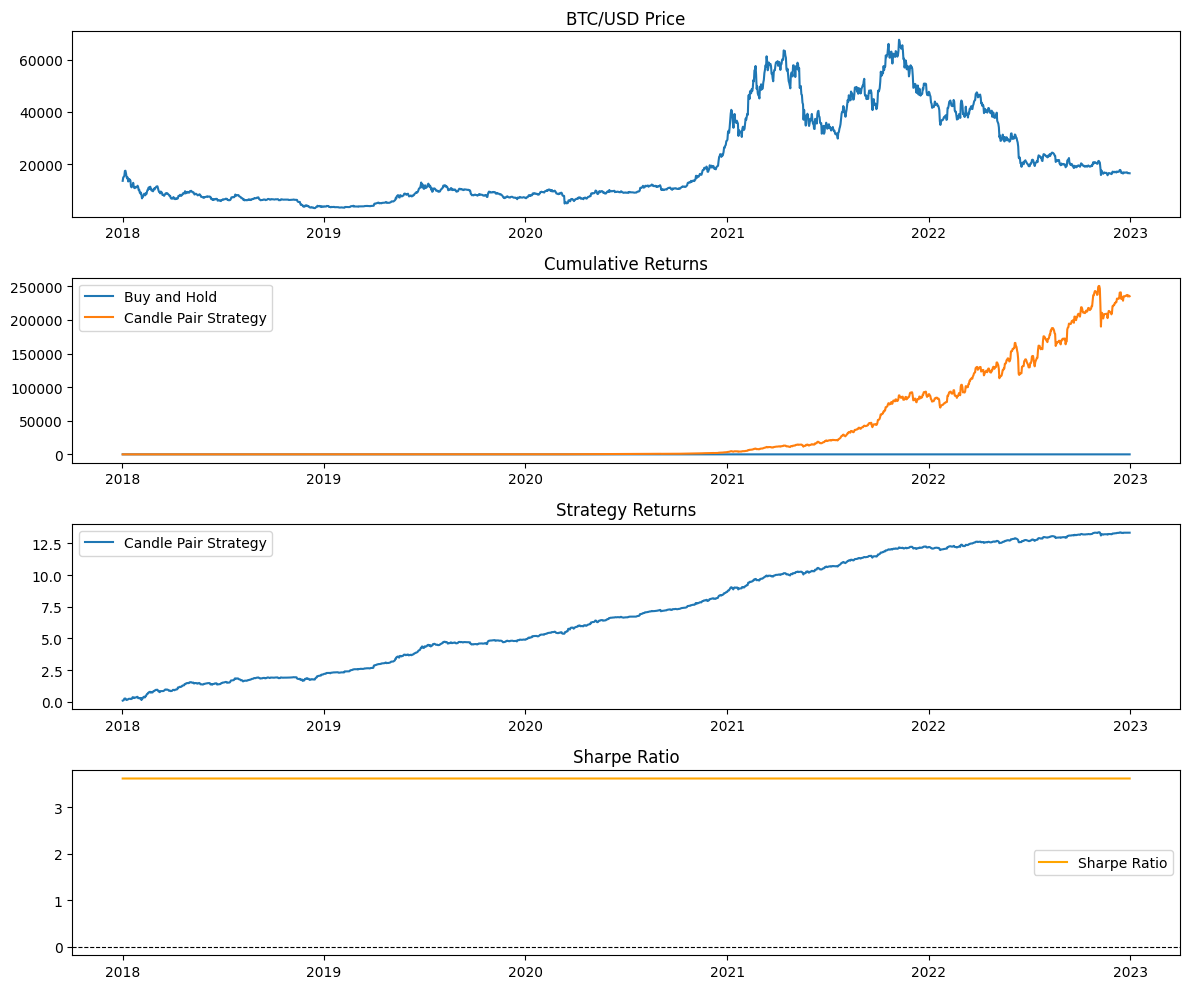

Sharpe Ratio: 3.6131


In [9]:
symbol = "BTC-USD"
start_date = "2018-01-01"
end_date = "2023-01-01"
data = yf.download(symbol, start=start_date, end=end_date)

# Identify pairs of adjacent red and green candles
data['CandleColor'] = 'None'
data['CandleColor'][data['Close'] > data['Open']] = 'Green'
data['CandleColor'][data['Close'] < data['Open']] = 'Red'
data['Position'] = 0
data['Consolidation'] = 0

current_trend = 'None'

for i in range(1, len(data)):
    if data['CandleColor'][i - 1] == 'Red' and data['CandleColor'][i] == 'Green':
        # Enter a long position if a pair of adjacent red and green candles is identified
        data['Position'][i] = 1
        current_trend = 'Up'
    elif data['CandleColor'][i - 1] == 'Green' and data['CandleColor'][i] == 'Red':
        # Exit the long position if the next pair of adjacent candles is identified
        data['Position'][i] = 0
        current_trend = 'Down'
    elif current_trend != 'None':
        # Continue holding the position during the trend
        data['Position'][i] = 1
data['DailyReturns'] = data['Close'].pct_change()
data['StrategyReturns'] = data['Position'] * data['DailyReturns']
data['CumulativeReturns'] = (1 + data['DailyReturns']).cumprod()
data['CumulativeStrategyReturns'] = (1 + data['StrategyReturns']).cumprod()

average_strategy_return = data['StrategyReturns'].mean()
std_dev_strategy_return = data['StrategyReturns'].std()
sharpe_ratio = np.sqrt(252)*average_strategy_return / std_dev_strategy_return

plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(data['Close'], label='BTC/USD')
plt.title('BTC/USD Price')

plt.subplot(4, 1, 2)
plt.plot(data['CumulativeReturns'], label='Buy and Hold')
plt.plot(data['CumulativeStrategyReturns'], label='Candle Pair Strategy')
plt.legend()
plt.title('Cumulative Returns')

plt.subplot(4, 1, 3)
plt.plot(data['StrategyReturns'].cumsum(), label='Candle Pair Strategy')
plt.legend()
plt.title('Strategy Returns')

plt.subplot(4, 1, 4)
sharpe_ratio_series = pd.Series(index=data.index, data=sharpe_ratio)
plt.plot(sharpe_ratio_series, label='Sharpe Ratio', color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.title('Sharpe Ratio')
plt.tight_layout()
plt.show()

print(f'Sharpe Ratio: {sharpe_ratio:.4f}')


Same startegy for 60 minute timeframe

[*********************100%%**********************]  1 of 1 completed


<ipython-input-10-de8eafbef226>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CandleColor'][data['Close'] > data['Open']] = 'Green'
<ipython-input-10-de8eafbef226>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CandleColor'][data['Close'] < data['Open']] = 'Red'
<ipython-input-10-de8eafbef226>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'][i] = 0
<ipython-input-10-de8eafbef226>:25: SettingWithCopyWa

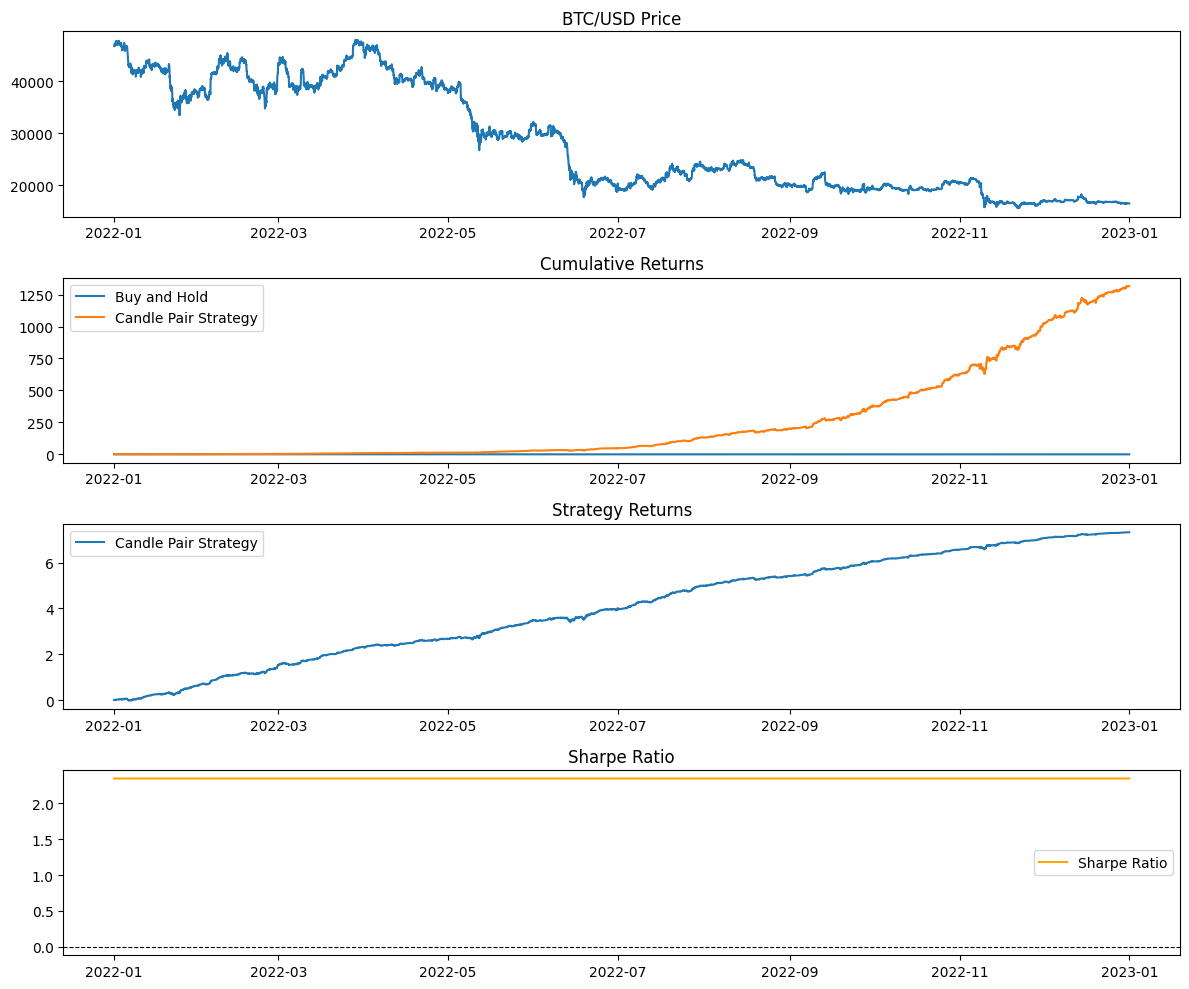

Sharpe Ratio: 2.3462


In [10]:
symbol = "BTC-USD"
start_date = "2022-01-01"
end_date = "2023-01-01"
data = yf.download(symbol, start=start_date, end=end_date, interval="60m")

data['CandleColor'] = 'None'
data['CandleColor'][data['Close'] > data['Open']] = 'Green'
data['CandleColor'][data['Close'] < data['Open']] = 'Red'
data['Position'] = 0
data['Consolidation'] = 0

current_trend = 'None'

for i in range(1, len(data)):
    if data['CandleColor'][i - 1] == 'Red' and data['CandleColor'][i] == 'Green':
        # Enter a long position if a pair of adjacent red and green candles is identified
        data['Position'][i] = 1
        current_trend = 'Up'
    elif data['CandleColor'][i - 1] == 'Green' and data['CandleColor'][i] == 'Red':
        # Exit the long position if the next pair of adjacent candles is identified
        data['Position'][i] = 0
        current_trend = 'Down'
    elif current_trend != 'None':
        # Continue holding the position during the trend
        data['Position'][i] = 1

data['DailyReturns'] = data['Close'].pct_change()
data['StrategyReturns'] = data['Position'] * data['DailyReturns']
data['CumulativeReturns'] = (1 + data['DailyReturns']).cumprod()
data['CumulativeStrategyReturns'] = (1 + data['StrategyReturns']).cumprod()

average_strategy_return = data['StrategyReturns'].mean()
std_dev_strategy_return = data['StrategyReturns'].std()
sharpe_ratio = np.sqrt(252)*average_strategy_return / std_dev_strategy_return

plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(data['Close'], label='BTC/USD')
plt.title('BTC/USD Price')

plt.subplot(4, 1, 2)
plt.plot(data['CumulativeReturns'], label='Buy and Hold')
plt.plot(data['CumulativeStrategyReturns'], label='Candle Pair Strategy')
plt.legend()
plt.title('Cumulative Returns')

plt.subplot(4, 1, 3)
plt.plot(data['StrategyReturns'].cumsum(), label='Candle Pair Strategy')
plt.legend()
plt.title('Strategy Returns')

plt.subplot(4, 1, 4)
sharpe_ratio_series = pd.Series(index=data.index, data=sharpe_ratio)
plt.plot(sharpe_ratio_series, label='Sharpe Ratio', color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.title('Sharpe Ratio')
plt.tight_layout()
plt.show()

print(f'Sharpe Ratio: {sharpe_ratio:.4f}')


In [ ]:
!pip install yfinance
import yfinance as yf
# Construct the ticker for the VIX
vix_ticker = yf.Ticker("^VIX")

# Use the history method to fetch the data
vix_data = vix_ticker.history(start="2018-01-01", end="2023-01-01")

